In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import os 
# import open3d as o3d
from kornia import create_meshgrid
os.chdir('../')
from src.threedsam.threedsam_modules.epipolar_attention import get_epipolar_line_std, get_mask, get_scaled_K
from src.datasets.scannet import ScanNetDataset


root_dir = '/media/morgen/T7/dataset/scannet_train'
npz_path = '/media/morgen/T7/dataset/scannet_indices/scene_data/train/scene0066_00.npz'
intrinsic_path = '/media/morgen/T7/dataset/scannet_indices/intrinsics.npz'
dpt_weight_path = '/home/morgen/projects/3DSAM/weights/dpt/dpt_hybrid_nyu-2ce69ec7.pt'
dataset = ScanNetDataset(root_dir, npz_path, intrinsic_path, dpt_weight_path)

/home/morgen/.conda/envs/3dsam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/morgen/.conda/envs/3dsam/lib/python3.8/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [2]:
batch = dataset[1025]
print(batch['pair_names'])
batch.keys()

# 3D 点云
pts_3d0 = batch['pts_3d0']
pts_3d1 = batch['pts_3d1']

# # 使用open3D计算法向量
# pcd0 = o3d.geometry.PointCloud()
# pcd1 = o3d.geometry.PointCloud()
# pcd0.points = o3d.utility.Vector3dVector(pts_3d0.cpu().numpy())
# pcd0.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# pcd1.points = o3d.utility.Vector3dVector(pts_3d1.cpu().numpy())
# pcd1.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# # # 可视化点云&法向量
# o3d.visualization.draw_geometries([pcd0], point_show_normal=False)
# o3d.visualization.draw_geometries([pcd1], point_show_normal=False)

('scene0066_00/color/830.jpg', 'scene0066_00/color/851.jpg')


In [4]:
pts_3d0.shape

torch.Size([307200, 3])

In [3]:
image0 = (batch['image0'] * 255).to(torch.uint8).squeeze().numpy()
image1 = (batch['image1'] * 255).to(torch.uint8).squeeze().numpy()
device = batch['image0'].device

K0 = K1 = batch['K0'].unsqueeze(dim=0).clone()
K0 = get_scaled_K(K0, 8)

T_0to1 = batch['T_0to1'].unsqueeze(0)
T_1to0 = batch['T_1to0'].unsqueeze(0)

R0, t0 = T_0to1[:, 0:3, 0:3], T_0to1[:, 0:3, [-1]] 
R1, t1 = T_1to0[:, 0:3, 0:3], T_1to0[:, 0:3, [-1]] 



depth0 = batch['depth0']
depth1 = batch['depth1']

In [4]:
image0_resized = cv2.resize(image0, (80, 60))
image1_resized = cv2.resize(image1, (80, 60))
coord = create_meshgrid(60, 80, False, device, torch.int64).flatten(1, 2)
lines, mode = get_epipolar_line_std(coord, R0, t0, K0, K1)
mask = get_mask(coord[0], lines, mode, 4)

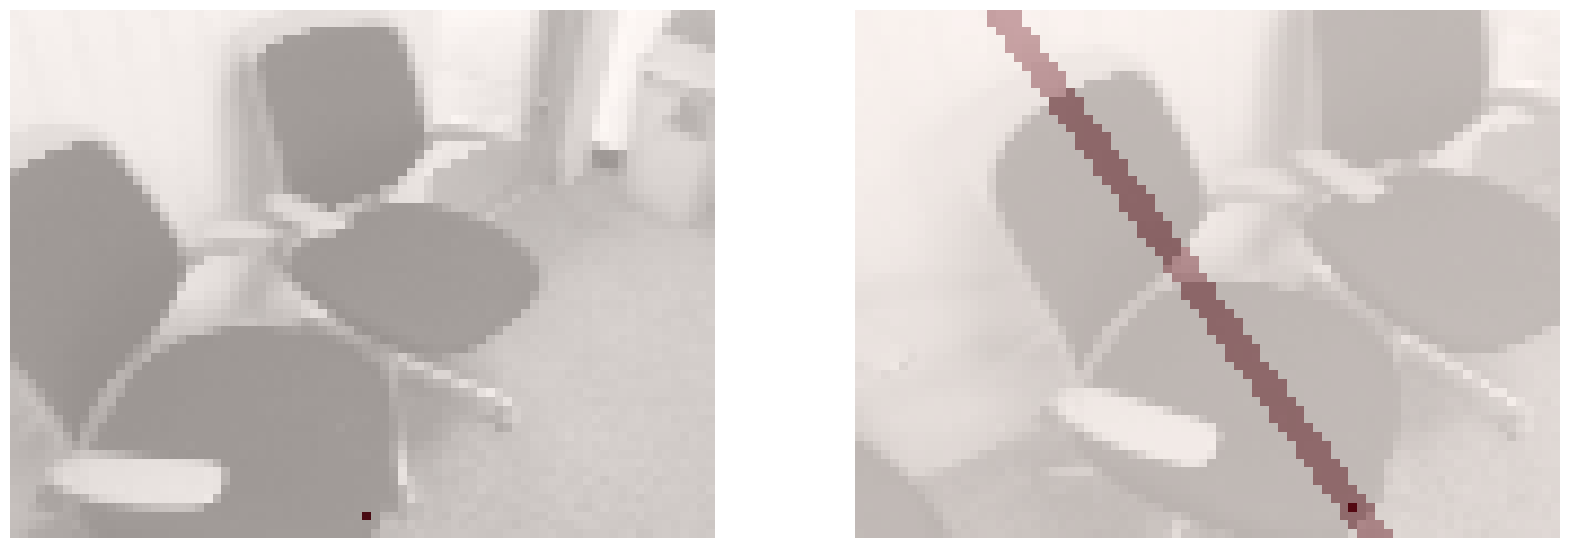

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15))

axs[0].imshow(image0_resized, cmap='gray')
axs[0].axis('off')

axs[1].imshow(image1_resized, cmap='gray')
axs[1].axis('off')

line_ids = 4600

row_ids = line_ids // 80
col_ids = line_ids % 80
point0 = torch.zeros((60, 80), dtype=torch.uint8)
point1 = torch.zeros((60, 80), dtype=torch.uint8)

# 将点0投影到图1
pt0 = torch.tensor([[col_ids, row_ids, 1]], dtype=torch.float32)  # [1, 3]
pt0_depth = pt0 * depth0[row_ids * 8, col_ids * 8]# [1, 3]
pt0_h = K0[0].inverse() @ pt0_depth.transpose(0, 1)  # [3, 1] 
pt1_depth = R0[0] @ pt0_h + t0[0]
pt1_h = (K1[0] @ pt1_depth).transpose(0, 1)  # [1, 3]
pt1 = (pt1_h[:, 0:2] / (pt1_h[:, [2]] + 1e-4)).long().squeeze()

point0[row_ids, col_ids] = 255
point1[pt1[1], pt1[0]] = 255
mask_within = mask[0][line_ids].view(60, 80)
row, col = torch.where(mask_within)
mask0 = torch.zeros((60, 80), dtype=torch.uint8)
mask0[row, col] = 255
axs[0].imshow(point0, cmap='Reds', alpha=0.6)
axs[1].imshow(point1, cmap='Reds', alpha=0.6)
axs[1].imshow(mask0, cmap='Reds', alpha=0.33)

plt.show()
